In [2]:
!ls /usr/local/share/notebooks/

Dask.ipynb  Example Notebook.ipynb  Untitled.ipynb  Untitled1.ipynb


Using Dask with Iris
====================

Can we used Dask delayed arrays instead of biggus arrays without Iris noticing?

First off install Dask an some tools to get from S3

In [8]:
!pwd

/usr/local/share/notebooks


In [7]:
!ls /usr/share/notebooks

ls: cannot access /usr/share/notebooks: No such file or directory


In [2]:
!conda install -y -c conda-forge dask distributed s3fs
!pip install castra graphviz
!apt-get install -y graphviz
!conda install -y lz4

Fetching package metadata .........
Solving package specifications: ..........

Package plan for installation in environment /opt/conda:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.1.12               |           py35_0         205 KB  conda-forge
    s3fs-0.0.7                 |           py35_0         198 KB  conda-forge
    dask-0.11.1                |           py35_0         846 KB  conda-forge
    distributed-1.13.3         |           py35_0         554 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.8 MB

The following packages will be UPDATED:

    distributed: 1.13.2-py35_2 --> 1.13.3-py35_0 conda-forge

The following packages will be SUPERCEDED by a higher-priority channel:

    conda:       4.2.9-py35_0  --> 4.1.12-py35_0 conda-forge
    conda-env:   2.6.0-0       --> 2.5

In [21]:
import iris
import dask
import s3fs
import os
from distributed import Executor, progress
import warnings

e = Executor('dask.informaticslab.co.uk:8786')
print(e)

%matplotlib inline

<Client: scheduler="dask.informaticslab.co.uk:8786" processes=9 cores=18>


In [ ]:
from bokeh.io import output_notebook
output_notebook()

Make and S3 filesystem object to get data from

In [25]:
@dask.delayed
def double(n):
    return n * 2

@dask.delayed
def inc(n):
    return n + 1

In [26]:
res = inc(double(2))

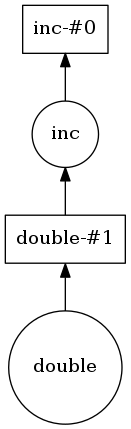

In [28]:
res.visualize()

In [30]:
res.compute()

5

In [10]:
fs = s3fs.S3FileSystem(anon=True)
myfiles = fs.ls('mogreps/2b6a')[:6]

FileNotFoundError: mogreps/2b6a

Now we define a function wich takes an S3 file and returns an Iris cube. We have to dump to disk and reload but it doesn't look like this is a massive overhead.

My decorating with `@delayed` we get a lazy object.

In [22]:
def myls():
    import os
    return os.listdir('/home/ubuntu/anaconda3/lib/python3.5/site-packages/')

In [23]:
e.run(myls)

{'172.31.10.171:56823': ['s3transfer',
  'path.py',
  'zict-0.0.3-py3.5.egg-info',
  'Biggus-0.14.0-py3.5.egg-info',
  'bokeh',
  'mistune-0.7.2-py3.5.egg-info',
  'nbpresent',
  'boto',
  'scikit_image-0.12.3-py3.5.egg-info',
  'boto-2.40.0-py3.5.egg-info',
  'Iris-1.10.0.dev0-py3.5.egg-info',
  'Werkzeug-0.11.10-py3.5.egg-info',
  'dask',
  'configobj.py',
  'pygments',
  'ipykernel-4.3.1-py3.5.egg-info',
  'zict',
  'openpyxl-2.3.2-py3.5.egg-info',
  'click-6.6-py3.5.egg-info',
  'ipython_genutils',
  'itsdangerous.py',
  'scikit_learn-0.17.1-py3.5.egg-info',
  'pyshp-1.2.3-py3.5.egg-info',
  'notebook',
  'dask-0.11.1-py3.5.egg-info',
  'shapely',
  'pycrypto-2.6.1-py3.5.egg-info',
  'boto3-1.4.0-py3.5.egg-info',
  'numba-0.26.0-py3.5-linux-x86_64.egg-info',
  'Sphinx-1.4.1-py3.5.egg',
  'jupyter_core-4.1.0-py3.5.egg-info',
  'rope_py3k-0.9.4_1-py3.5.egg-info',
  'python_dateutil-2.5.3-py3.5.egg-info',
  'pep8.py',
  'fastcache',
  'flask',
  'QtPy-1.0.2-py3.5.egg-info',
  'shapefi

In [17]:
# def patch_biggus_with_dask(biggus_array, chunks=None):
#     if not chunks:
#         chunks = biggus_array.shape
#     dask_array = dask.array.from_array(biggus_array, chunks=chunks)
#     for prop in dask_array.__dir__():
#         if prop not in biggus_array.__dir__():
#             setattr(biggus_array, prop, getattr(dask_array, prop))
#     return biggus_array

@dask.delayed
def pull_s3_to_cube(myfile):
    dumpfile = "/tmp/"+os.path.split(myfile)[-1]
    with open(dumpfile, 'wb') as fout:
        with fs.open(myfile, 'rb') as fin:
            fout.write(fin.read())
    cube = iris.load_cube(dumpfile, "surface_temperature")
#     cube._my_data = patch_biggus_with_dask(cube._my_data)
    
    return cube

In [5]:
delayed_cubes = []
for myfile in myfiles:
    delayed_cubes.append(pull_s3_to_cube(myfile))
delayed_delayed_cubes = dask.delayed(delayed_cubes)

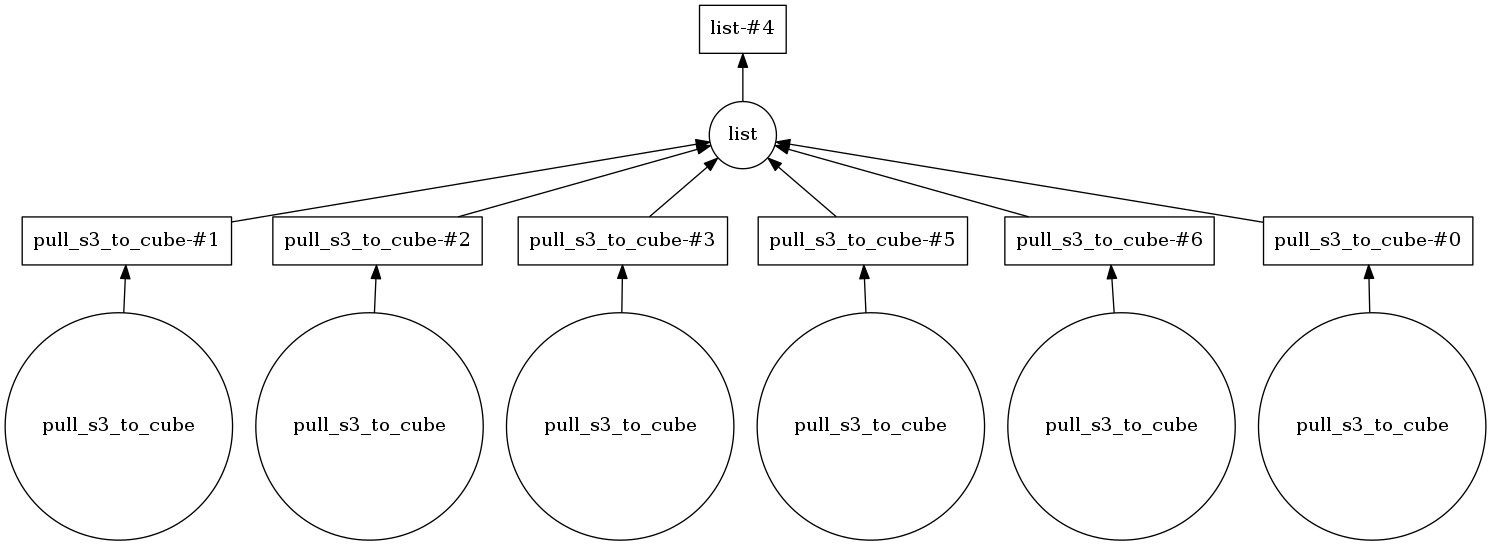

In [6]:
delayed_delayed_cubes.visualize() # takes a long time to run with many files

In [7]:
cubes = delayed_delayed_cubes.compute()

In [8]:
cubes

[<iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>]

Iris is very good at merging cubes with lazy data into supercubes. We can merge these lazy cubes.

In [18]:
cubes

[<iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>,
 <iris 'Cube' of surface_temperature / (K) (time: 2; latitude: 600; longitude: 800)>]

In [9]:
_cubes = []
for cube in cubes:
    _cubes.append(cube[0])
    _cubes.append(cube[1])
    
cube = iris.cube.CubeList(_cubes).merge_cube() # this is just data specific bullshit

In [10]:
print(cube)

surface_temperature / (K)           (forecast_period: 2; forecast_reference_time: 6; latitude: 600; longitude: 800)
     Dimension coordinates:
          forecast_period                           x                           -            -               -
          forecast_reference_time                   -                           x            -               -
          latitude                                  -                           -            x               -
          longitude                                 -                           -            -               x
     Auxiliary coordinates:
          time                                      x                           x            -               -
     Attributes:
          STASH: m01s00i024
          source: Data from Met Office Unified Model
          um_version: 10.2


Iris has just merged by concatenating/stacking all the biggus arrays, but I think we want to be doing this with dask

In [11]:
print(cubes[0]._my_data)

<Array shape=(2, 600, 800) dtype=dtype('float32') size=3.66 MiB>


In [12]:
a = dask.array.concatenate([dask.array.from_array(_._my_data, chunks=_.shape) for _ in cubes[:3]], axis=0)
b = dask.array.concatenate([dask.array.from_array(_._my_data, chunks=_.shape) for _ in cubes[3:]], axis=0)
cube_data = dask.array.stack([a, b], axis=0)

In [13]:
cube_data

dask.array<stack-d..., shape=(2, 6, 600, 800), dtype=float32, chunksize=(1, 2, 600, 800)>

In [14]:
lazy_mean = cube_data.mean()

In [15]:
print(lazy_mean)

dask.array<mean_ag..., shape=(), dtype=float32, chunksize=()>


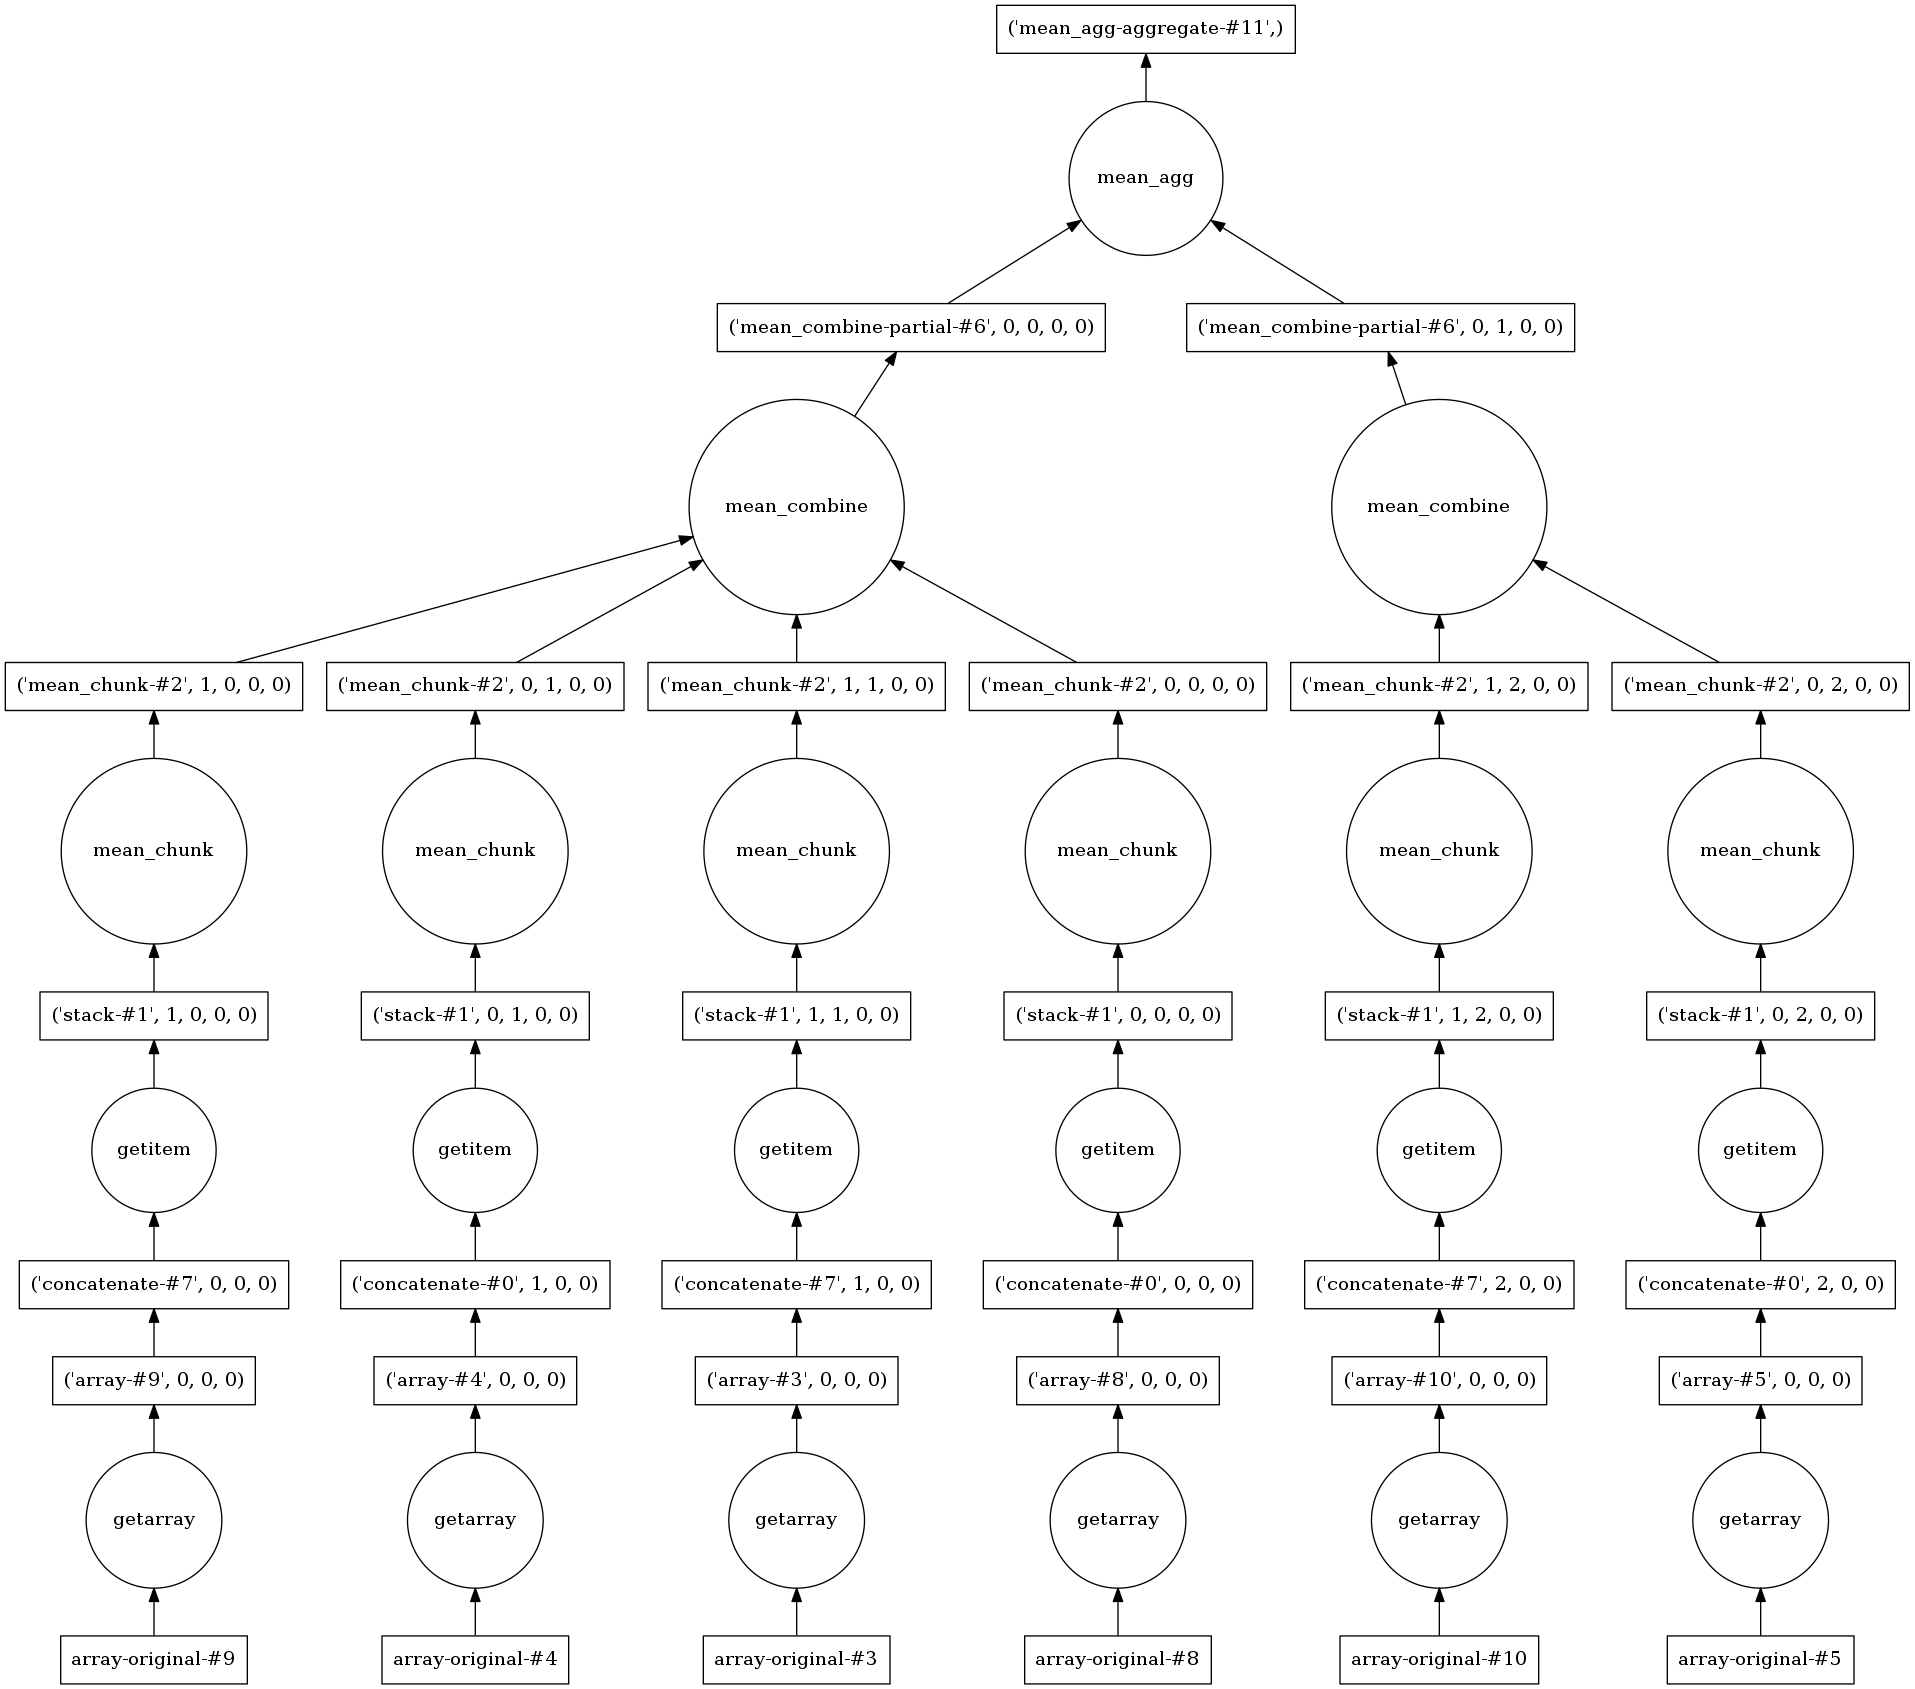

In [16]:
lazy_mean.visualize()

In [18]:
lazy_mean.compute()

281.62701

Try just with Biggus Arrays
===========================

based on http://matthewrocklin.com/blog/work/2016/02/26/dask-distributed-part-3

In [50]:
from distributed.collections import futures_to_dask_arrays
import dask.array as da

def pull_s3_to_arr(myfile):
    dumpfile = "/tmp/"+os.path.split(myfile)[-1]
    if not os.path.isfile(dumpfile):
        with open(dumpfile, 'wb') as fout:
            with fs.open(myfile, 'rb') as fin:
                fout.write(fin.read())
    cube = iris.load_cube(dumpfile, "surface_temperature")
    myarr = cube.data
    return myarr

In [51]:
futures = e.map(pull_s3_to_arr, myfiles)

In [52]:
arrs = futures_to_dask_arrays(futures)

In [53]:
arr = da.concatenate(arrs, axis=0)

In [54]:
subarr = arr[:, 100:200, 300:400]

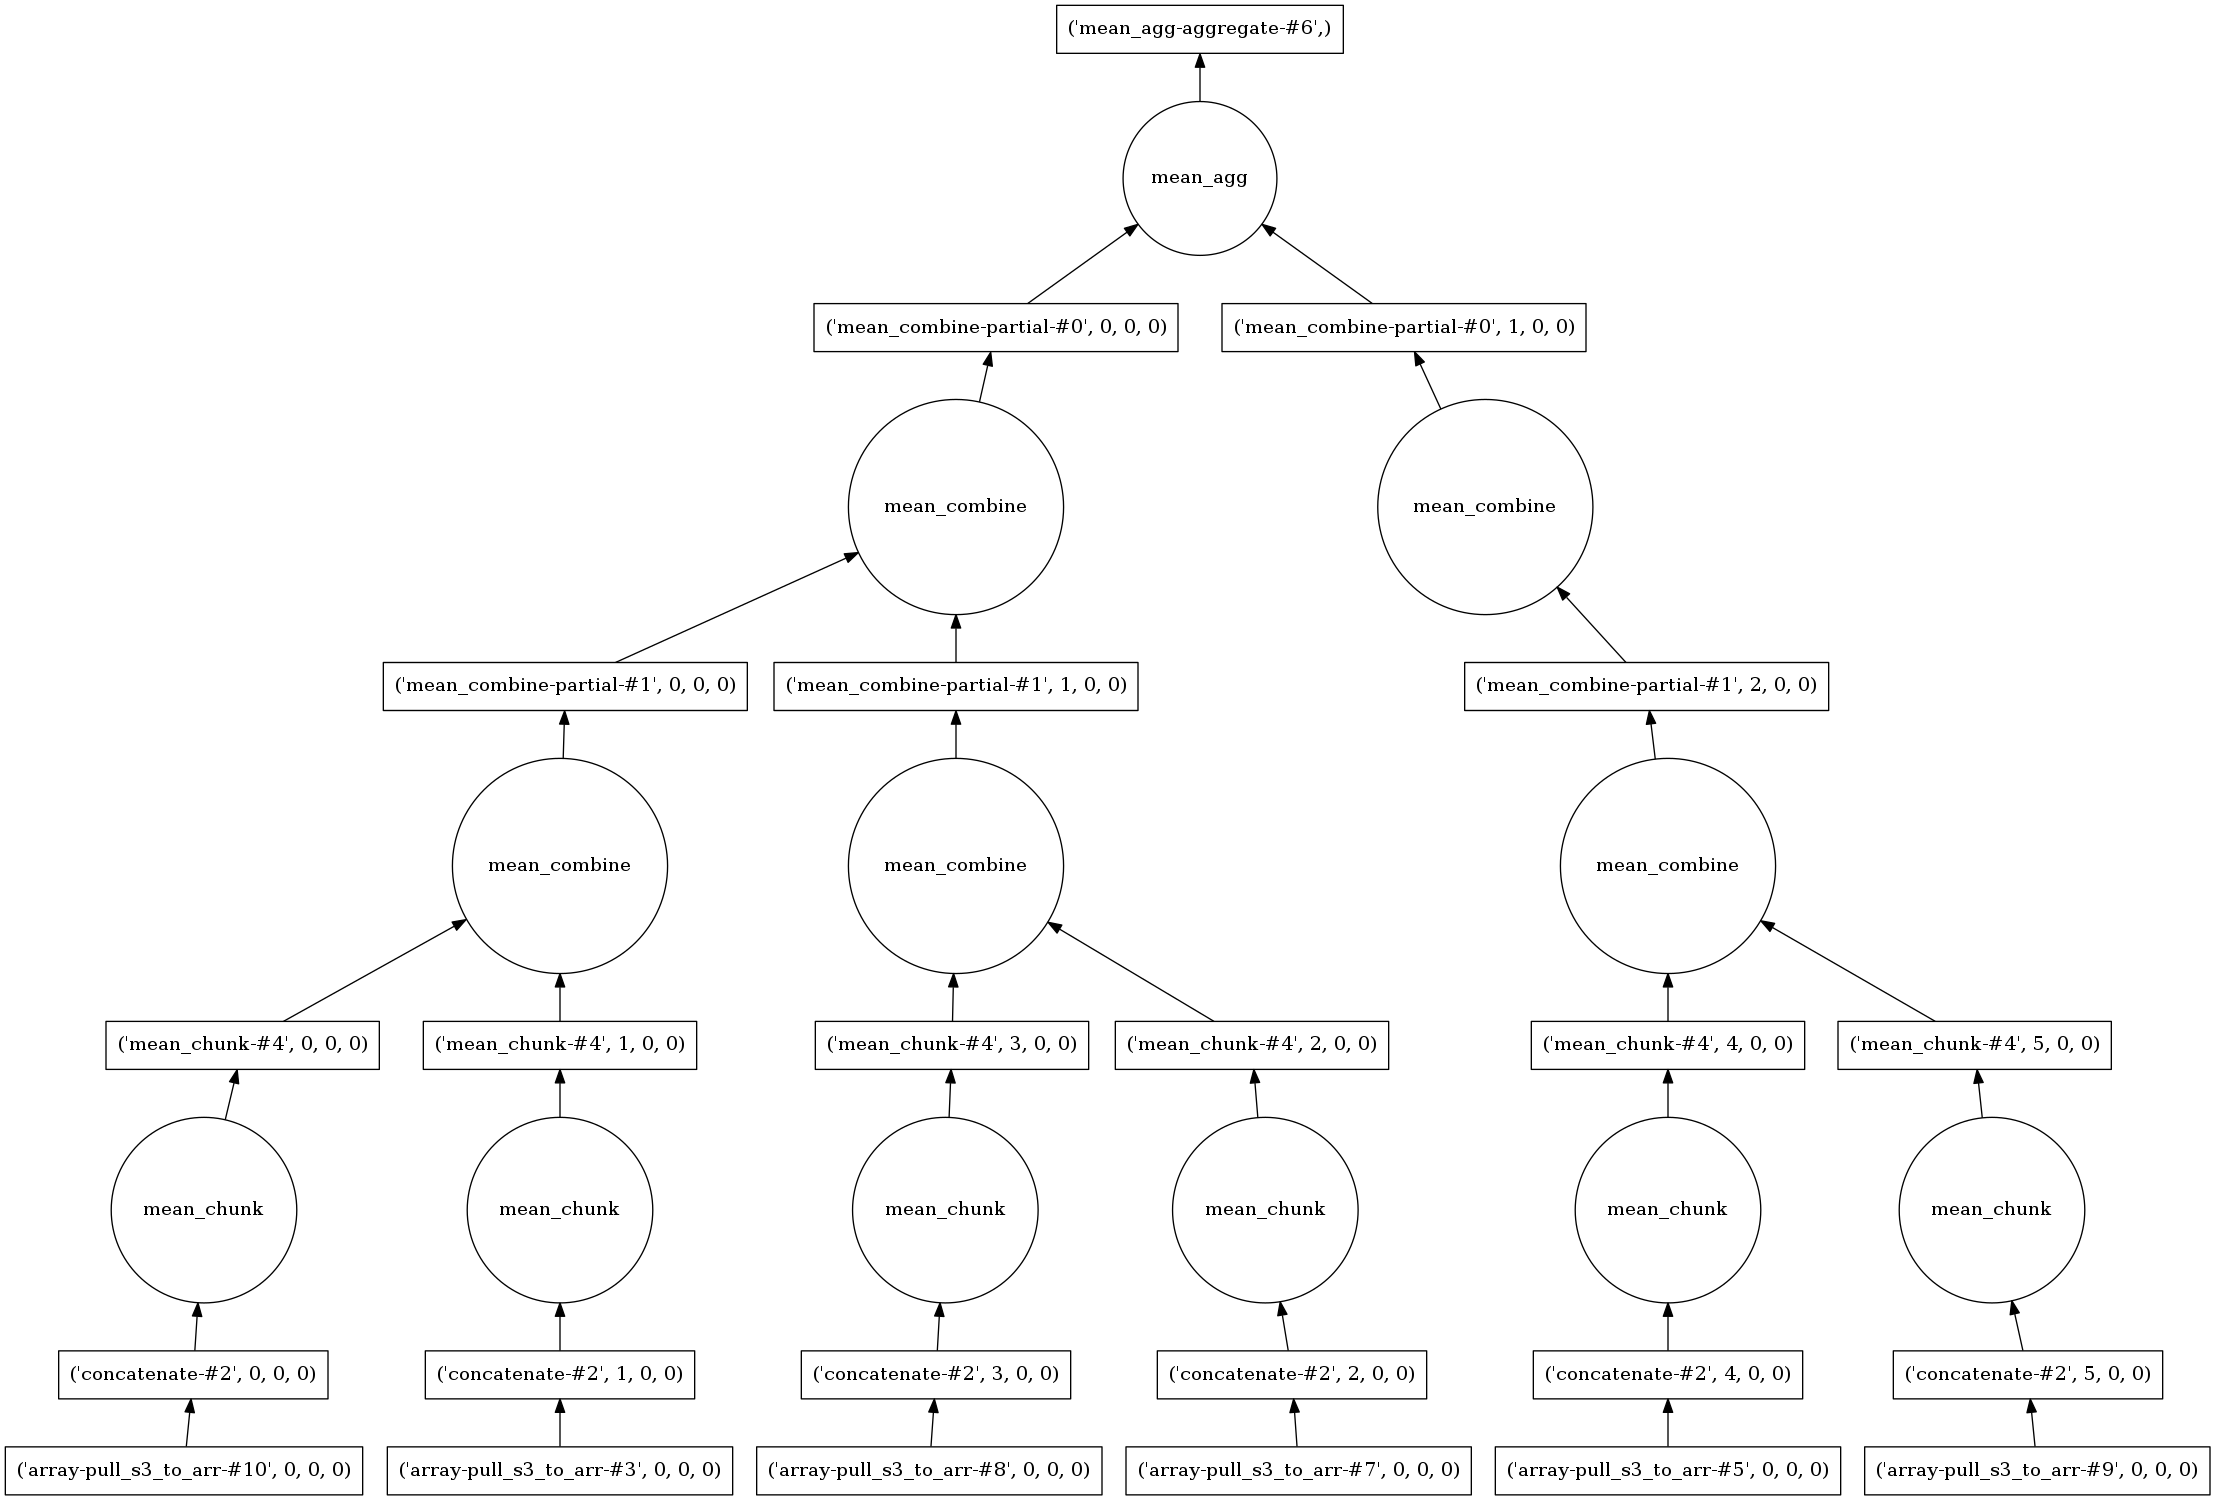

In [55]:
lazy_mean = arr.mean()
lazy_mean.visualize()

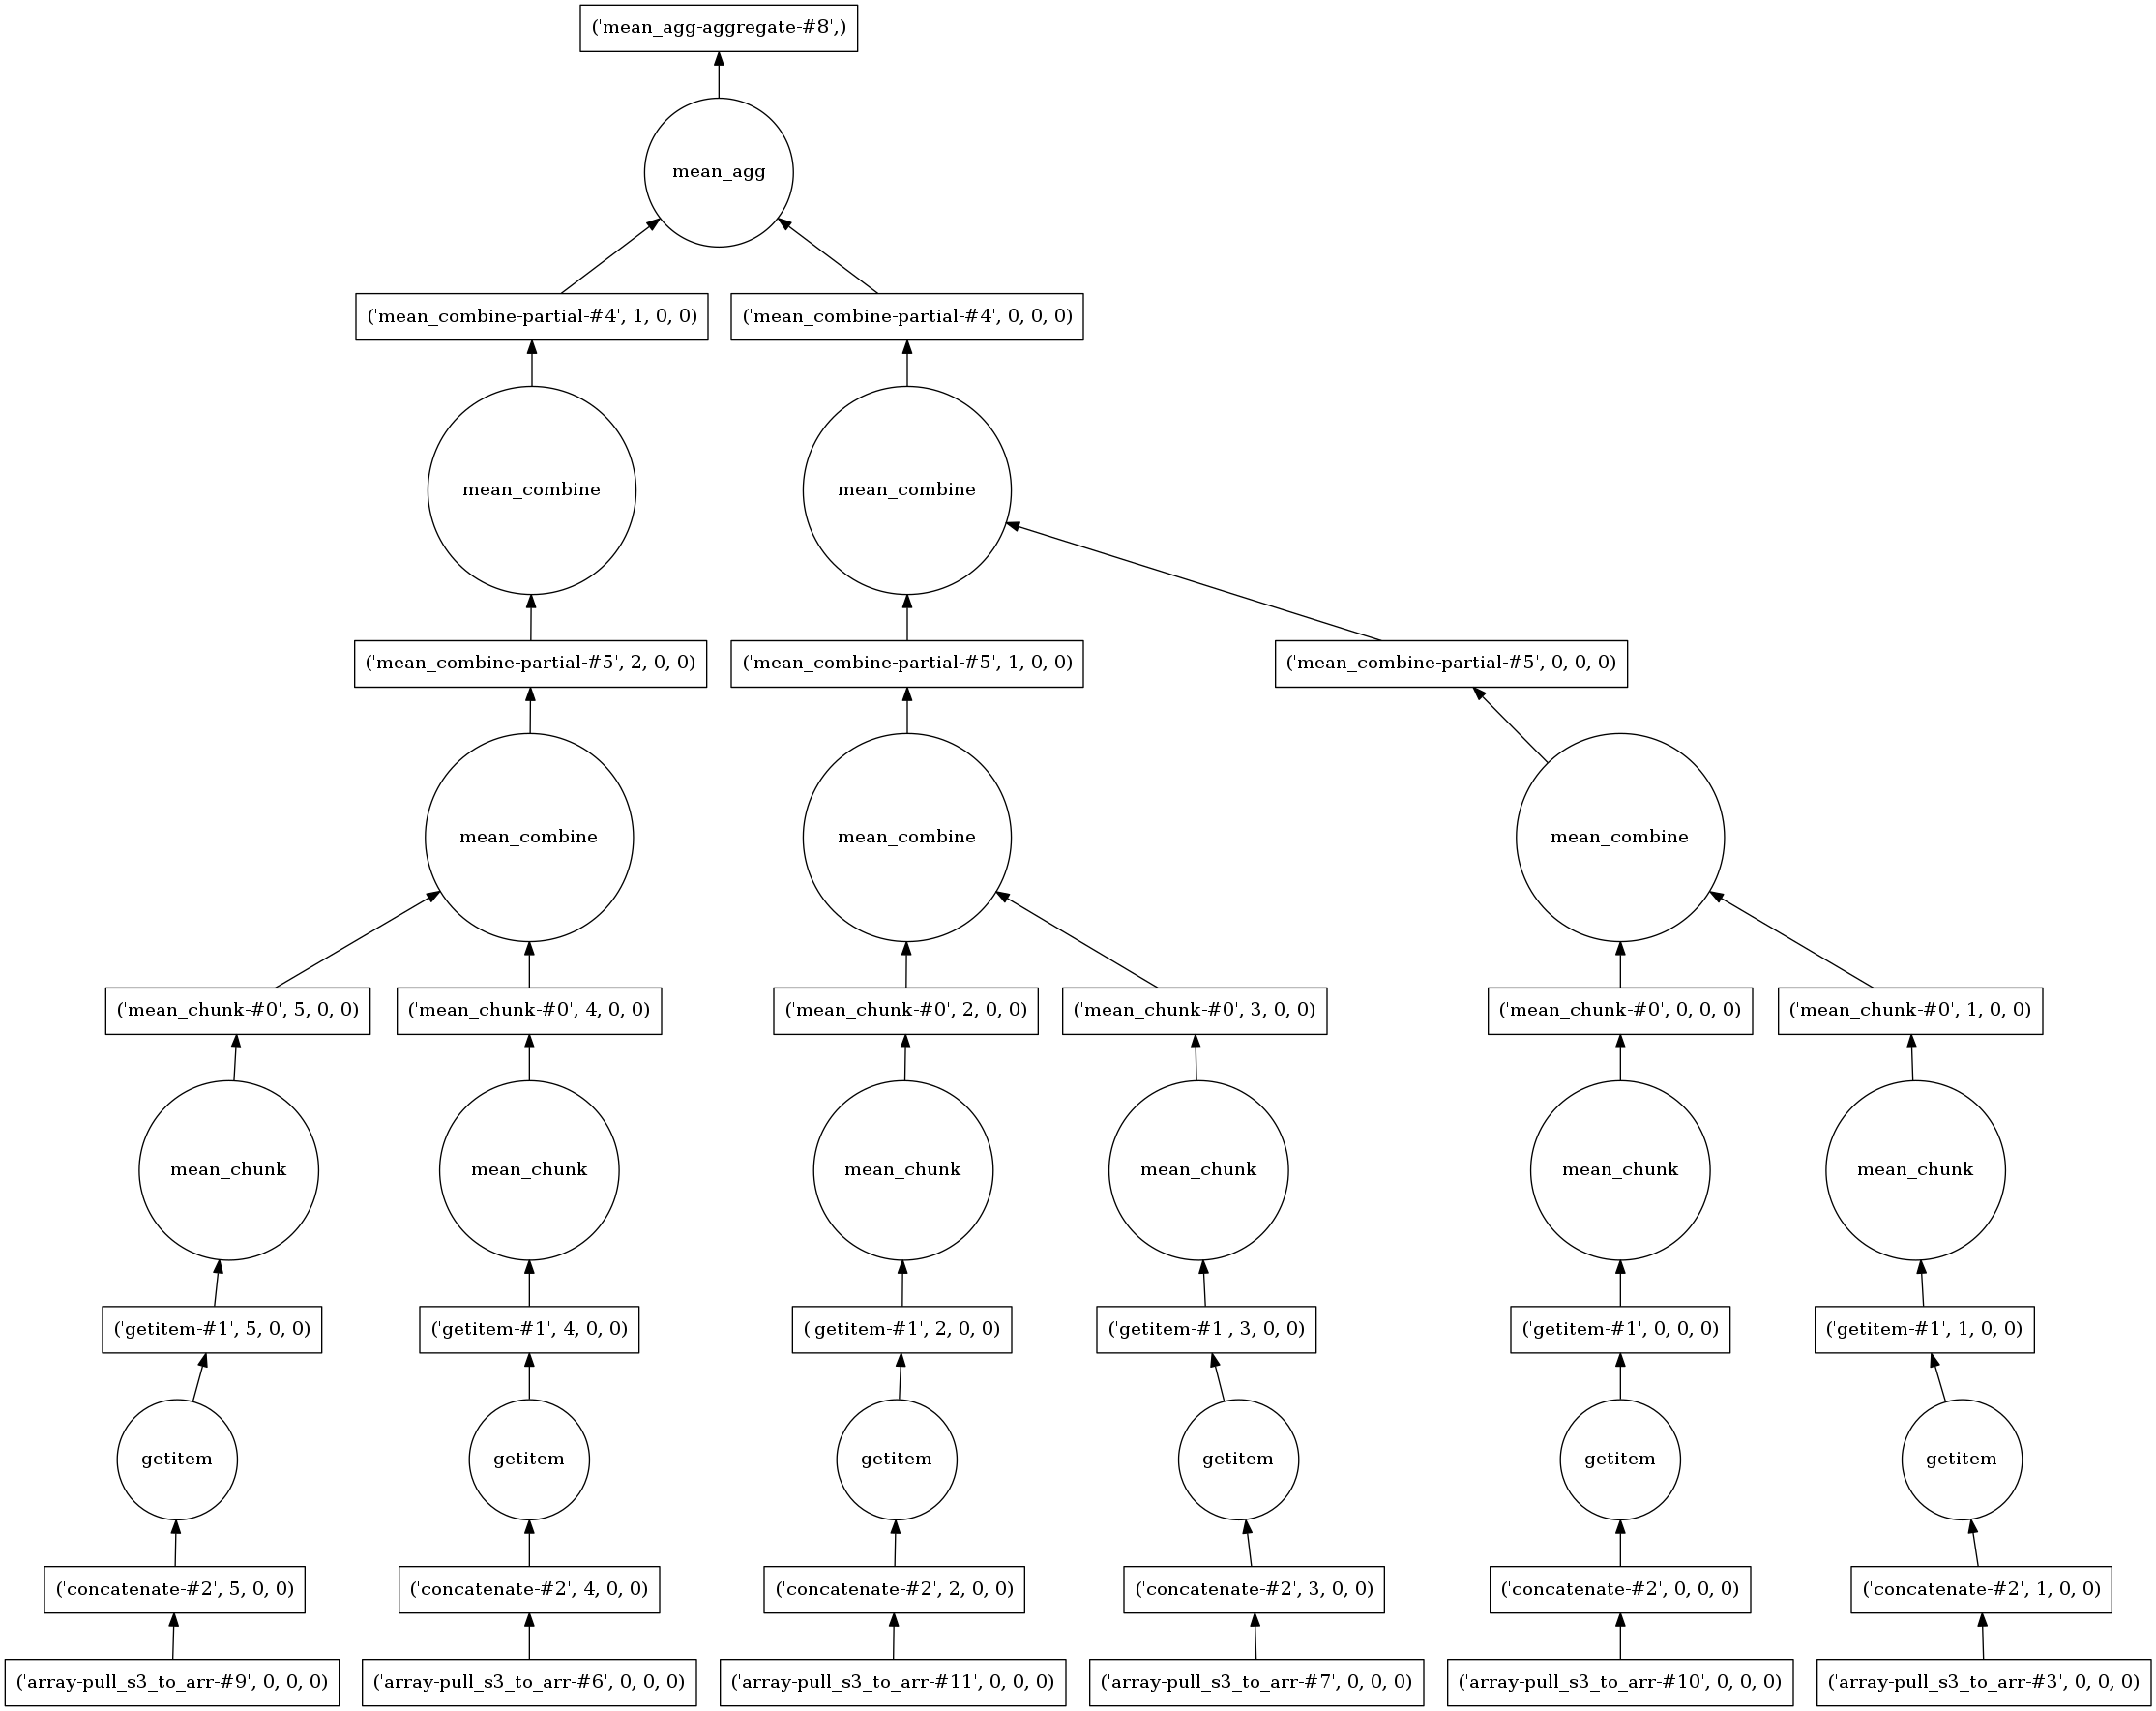

In [56]:
sub_lazy_mean = subarr.mean()
sub_lazy_mean.visualize()

In [57]:
lazy_mean.compute()

281.62701

In [58]:
sub_lazy_mean.compute()

283.03793

Add this to a cube
===================

In [4]:
from distributed.collections import futures_to_dask_arrays
import dask.array as da
import os.path

def pull_s3_to_arr(myfile):
    dumpfile = "/tmp/"+os.path.split(myfile)[-1]
    if not os.path.isfile(dumpfile):
        with open(dumpfile, 'wb') as fout:
            with fs.open(myfile, 'rb') as fin:
                fout.write(fin.read())
    cube = iris.load_cube(dumpfile, "surface_temperature")
#     cube._my_data = patch_biggus_with_dask(cube._my_data)
    myarr = cube._my_data
    return myarr


def pull_s3_to_cube(myfile):
    dumpfile = "/tmp/"+os.path.split(myfile)[-1]
    if not os.path.isfile(dumpfile):
        with open(dumpfile, 'wb') as fout:
            with fs.open(myfile, 'rb') as fin:
                fout.write(fin.read())
    cube = iris.load_cube(dumpfile, "surface_temperature")
#     cube._my_data = patch_biggus_with_dask(cube._my_data)
    myarr = cube._my_data
    return myarr
    

arr_futures = e.map(pull_s3_to_arr, myfiles)
cube_futures = e.map(pull_s3_to_cube, myfiles)

In [5]:
arr_futures

[<Future: status: pending, key: pull_s3_to_arr-ad88780bf9abbf8023ee5eb1ffd5712a>,
 <Future: status: pending, key: pull_s3_to_arr-e0336f975191b90461e4b356cd168a8f>,
 <Future: status: pending, key: pull_s3_to_arr-7f11feebb92b9662f02fa73bbfeaefbe>,
 <Future: status: pending, key: pull_s3_to_arr-6307aa699631e8ecc7060639b19fe2d2>,
 <Future: status: pending, key: pull_s3_to_arr-d879b825a81df03b9042ceadb40ee991>,
 <Future: status: pending, key: pull_s3_to_arr-f0fbc3e208e44a0e69a0e1121629f324>]

In [ ]:
arrs = futures_to_dask_arrays(arr_futures)